## Loading files

### Setup

In [60]:
!pip install pyconll torchtext livelossplot

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!curl https://raw.githubusercontent.com/UniversalDependencies/UD_Ancient_Greek-Perseus/master/grc_perseus-ud-train.conllu -o data/perseus-conllu/grc_perseus-ud-train.conllu
!curl https://raw.githubusercontent.com/UniversalDependencies/UD_Ancient_Greek-Perseus/master/grc_perseus-ud-dev.conllu -o data/perseus-conllu/grc_perseus-ud-dev.conllu
!curl https://raw.githubusercontent.com/UniversalDependencies/UD_Ancient_Greek-Perseus/master/grc_perseus-ud-test.conllu -o data/perseus-conllu/grc_perseus-ud-test.conllu

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.1M  100 14.1M    0     0  3242k      0  0:00:04  0:00:04 --:--:-- 3242k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2033k  100 2033k    0     0  2307k      0 --:--:-- --:--:-- --:--:-- 2307k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1933k  100 1933k    0     0  2423k      0 --:--:-- --:--:-- --:--:-- 2423k


### Parsing

In [2]:
import pyconll

In [3]:
def parse_into_list(body):
    data = []
    for sentence in body:
        sentence_words = []
        sentence_tags = []
        for token in sentence:
            sentence_words.append(token.form)
            sentence_tags.append(token.upos)

        if len(sentence_words) > 0:
            data.append((sentence_words, sentence_tags))
    
    return data

In [15]:
train_file = pyconll.load_from_file('data/perseus-conllu/grc_perseus-ud-train.conllu')
val_file = pyconll.load_from_file('data/perseus-conllu/grc_perseus-ud-dev.conllu')

train = parse_into_list(val_file)
val = parse_into_list(val_file)

len(train),len(val)

(1137, 1137)

In [16]:
word_to_ix = {}
for words, tags in train:
    for word in words:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
len(word_to_ix)

6899

In [17]:
tag_to_ix = {}
for sent, tags in train:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

len(tag_to_ix)

13

## Model setup

Based on https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils

from model.lstm import LSTMTagger

In [65]:
torch.manual_seed(1)

EMBEDDING_DIM = 100
HIDDEN_DIM = 20

In [66]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

## Model training

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from livelossplot import PlotLosses

%matplotlib inline

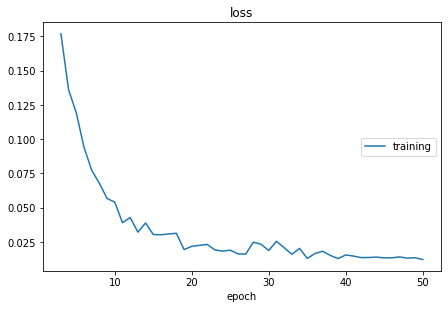

loss:
training   (min:    0.012, max:    0.312, cur:    0.012)


In [69]:
# TODO: evaluate loss on separate validation dataset

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=0)
train_losses = []
liveloss = PlotLosses()

for epoch in range(50):
    logs = {}
    total_loss = 0

    for i, data in enumerate(train_loader):        
        model.zero_grad()
        
        for i in range(len(data[0])):
            sentence = data[0][i]
            tags = data[1][i]
            
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)

            tag_scores = model(sentence_in)

            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss

    epoch_loss = total_loss / len(train)
    
    logs['loss'] = epoch_loss
    liveloss.update(logs)
    liveloss.draw()
    
#     print('Epoch %d: %.4f' % (epoch, total_loss / len(train)))
    train_losses.append(total_loss / len(train))

## Inference

In [70]:
ix_to_tag = {v: k for k, v in tag_to_ix.items()}
ix_to_tag

{0: 'DET',
 1: 'ADV',
 2: 'ADP',
 3: 'PRON',
 4: 'CCONJ',
 5: 'ADJ',
 6: 'VERB',
 7: 'NOUN',
 8: 'PUNCT',
 9: 'SCONJ',
 10: 'INTJ',
 11: 'NUM',
 12: 'X'}

In [75]:
sentence = train[0][0] # first sentence in the validation dataset

with torch.no_grad():
    inputs = prepare_sequence(sentence, word_to_ix)
    token_scores = model(inputs)
    print([max(token_tags).item() for token_tags in token_scores])
    tag_ix = [round(max(token_tags).item()) for token_tags in token_scores]
    tags = [ix_to_tag[tag] if tag in ix_to_tag else '' for tag in tag_ix]

    for word, tag in zip(sentence, tags):
        print('%s=%s ' % (word, tag), end = ' ')

[-0.00021038226259406656, -0.0005270045949146152, -0.0036677727475762367, -0.23967194557189941, -0.06116347014904022, -7.760223525110632e-05, -0.00014959646796341985, -0.15902994573116302, -0.10238080471754074, -0.00019810620869975537, -0.0065076337195932865, -0.0013331820955500007, -0.00029774048016406596, -0.00039081089198589325, -0.0012550819665193558, -0.0001248043408850208, -0.00019786784832831472, -9.595887240720913e-05, -0.0023510216269642115, -0.03195293992757797, -0.11034657061100006, -0.0008885487914085388, -0.9656308889389038, -0.28252488374710083, -0.007447100710123777, -0.04013049602508545, -0.04466025531291962, -0.0011718557216227055, -0.010748823173344135, -0.29714110493659973, -0.0003636414185166359, -0.04306214302778244, -0.00016020445036701858, -0.0003023882454726845, -0.013412837870419025, -0.033986896276474, -0.0001003691868390888, -0.00012373158824630082, -0.0026642323937267065, -0.0010284854797646403]
τὰ=DET  γὰρ=DET  πρὸ=DET  αὐτῶν=DET  καὶ=DET  τὰ=DET  ἔτι=DET  